## KNN Model Training and Hyperparameter Tuning

In [60]:
# Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cluster_log_transform import Cluster_Log # This is our handmade function!
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE

# Display setting set to view whole notebook end to end
pd.set_option('display.max_columns',100)

#### Notebook Structure:
- Preliminary Prep
- Initial Baseline Model
- SMOTE
- Fine Tuning

---

### Preliminary Prep

Let's start by loading the data in and doing similar adjustments as done in the EDA.ipynb file:

In [61]:
# Importing data
raw_data = pd.read_csv("online_shoppers_intention.csv")

# Converting certain numerical columns to categorical
num_to_cat_cols = ["OperatingSystems", "Browser", "Region", "TrafficType"]
raw_data[num_to_cat_cols] = raw_data[num_to_cat_cols].astype("category")

# Print original shape, drop duplicates, and print shape to verify
print(raw_data.shape)
clean_data = raw_data.drop_duplicates().reset_index(drop = True)
print(clean_data.shape)

(12330, 18)
(12205, 18)


Now, we will create our design matrix $X$ and response vector $Y$:

In [62]:
# Creating a list of the categorical features to create dummy variables and add them to X
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", 
            "TrafficType", "VisitorType", "Weekend"]
dummy_cols = pd.get_dummies(clean_data[cat_cols])

# Separating clean data into X and Y
X = clean_data.iloc[:,:-1]
Y = clean_data.iloc[:,-1]

# Getting rid of cat cols and replacing them with dummy cols
X = pd.concat([X.drop(columns=cat_cols), dummy_cols.astype(int)], axis=1)

Now, we create the preprocessor that will be used before each time we model. 

**Note: `Cluster_Log` is a function we came up with to transform our dataset how we wanted. It conducts KMeans clustering with k = 5, log(x + 1) transforms some of the columns, and returns X and Y how we want them**

In [63]:
# Cluster_Log requires the names of the numerical columns
num_df = clean_data.select_dtypes(include=["int64", "float64"])
num_cols = num_df.columns

# Creating preprocessor using ColumnTransformer
preprocessor = ColumnTransformer([("add_clusters_and_log", Cluster_Log(k = 5), num_cols)],
                                remainder = "passthrough")

---

### Initial Baseline Model

First model will a vanilla (plain) KNN. We will use a `Pipeline` to stream line the process:

In [64]:
# Creating pipeline
vanilla_pipe = Pipeline(steps = [
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsClassifier())
])

# Train test split ('stratify = Y' and 'shuffle = True' due to class imbalance)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, test_size=0.2, random_state= 88, shuffle=True)

# Fitting model
vanilla_model = vanilla_pipe.fit(X_train, Y_train)

Next, let's get the predictions and probabilities to get a weighted F1 score, classification report, and AUC score:

Vanilla KNN Weighted F1 Score: 0.87

Vanilla KNN Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.94      0.89      0.92      2059
   Purchase Made       0.54      0.72      0.62       382

        accuracy                           0.86      2441
       macro avg       0.74      0.80      0.77      2441
    weighted avg       0.88      0.86      0.87      2441


Vanilla KNN AUC Score: 0.87


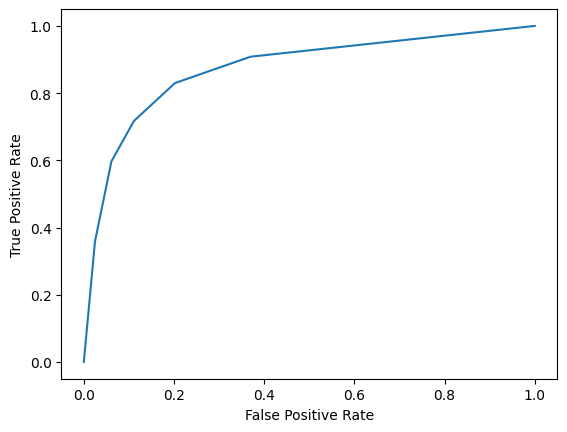

In [81]:
# Predictions and probabilities
y_pred = vanilla_model.predict(X_test)
y_proba = vanilla_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
vanilla_f1 = f1_score(Y_test, y_pred, average = "weighted")
print(f"Vanilla KNN Weighted F1 Score: {vanilla_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Vanilla KNN Classification Report")
print(classification_report(Y_test, y_pred, target_names = class_names))
print()

# Simple function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    """
    Plots the ROC curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(Y_test, y_proba)
print(f'Vanilla KNN AUC Score: {roc_auc_score(Y_test, y_proba):.2f}')

*Initial Model Conclusion*: Model is accurately predicting the non-purchasers but, the model has a bit more trouble with the purchasers. Weighted F1 score is evidence of that discrepancy but the weighted F1 and AUC scores are pretty good. Next, we will fit the model using SMOTE.

### Using SMOTE for Vanilla Model

The motivation for this lies in our poor performance in the minority class prediction. We hope for all models, SMOTE's resampling helps elevate that prediction power. We expect these results to be worse for KNN though since SMOTE relies on synthetically creating points, which messes with structure of the "neighborhood" of the dataset. However, since we are applying it to all models, we'd rather be consistent and apply it to KNN as well. More info on SMOTE can be found on final report. Here is the same implementation as the previous section but with SMOTE:

In [68]:
# Create SMOTE object
smote = SMOTE(random_state = 88, sampling_strategy = 0.6) # Make minority 60% of majority
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

# Fitting model
vanilla_smote_model = vanilla_pipe.fit(X_train_res, Y_train_res)

Vanilla KNN (with SMOTE) Weighted F1 Score: 0.87

Vanilla KNN (with SMOTE) Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.94      0.89      0.92      2059
   Purchase Made       0.54      0.72      0.62       382

        accuracy                           0.86      2441
       macro avg       0.74      0.80      0.77      2441
    weighted avg       0.88      0.86      0.87      2441


Vanilla KNN (with SMOTE) AUC Score: 0.87


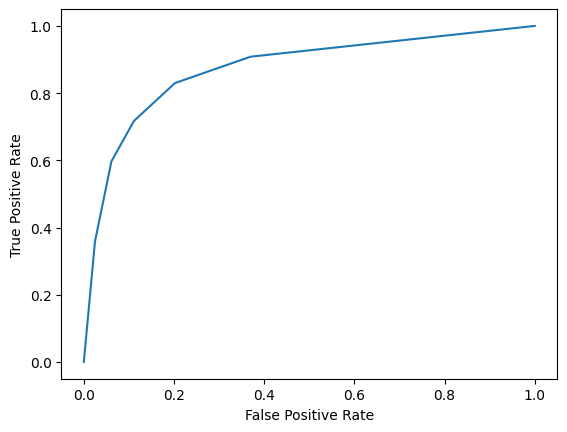

In [82]:
# Predictions and probabilities
y_pred_smote = vanilla_smote_model.predict(X_test)
y_proba_smote = vanilla_smote_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
vanilla_smote_f1 = f1_score(Y_test, y_pred_smote, average = "weighted")
print(f"Vanilla KNN (with SMOTE) Weighted F1 Score: {vanilla_smote_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Vanilla KNN (with SMOTE) Classification Report")
print(classification_report(Y_test, y_pred_smote, target_names = class_names))
print()
    
plot_roc_curve(Y_test, y_proba_smote)
print(f'Vanilla KNN (with SMOTE) AUC Score: {roc_auc_score(Y_test, y_proba_smote):.2f}')

---

### Fine-Tuning Model

We will be using `GridSearchCV` to tune the following hyperparameters:

In [76]:
# Couple remarks about the grid:
# - K values are odd to avoid ties
# - P is a hyperparameter that controls KNN using manhattan or euclidean distance
# - 'classifier__" is added to the beginning to make sure pipeline reads it correctly
param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2]
}

Now, we'll define our `GridSearchCV`:

In [89]:
# KFold cross val
kf = KFold(5, shuffle = True, random_state = 88)

# Creating grid search grid
grid = GridSearchCV(estimator=vanilla_pipe, param_grid=param_grid_knn, 
                    cv=kf, scoring="f1_weighted", n_jobs=-1, verbose=0)

Following this, we will perform grid search to find the optimal parameters for our model:

In [92]:
# Fitting grid onto training data
grid.fit(X_train, Y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'classifier__n_neighbors': [3, 5, ...], 'classifier__p': [1, 2], 'classifier__weights': ['uniform', 'distance']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('add_clusters_and_log', ...)]"


Printing the optimal parameters:

In [93]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best F1 score: {grid.best_score_:.2f}")

Best Parameters: {'classifier__n_neighbors': 15, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best F1 score: 0.88
